**Getting Started**

This tutorial relies on standard python packages as well as [SimPEG](http://simpeg.xyz). If you do not have SimPEG installed, you can uncomment the next line and install it from [pypi](https://pypi.python.org/pypi/SimPEG).

In [1]:
# !pip install SimPEG

# Forward simulation the 1D Magnetotelluric (MT) problem

In the [previous notebook](./MT1D_Simulation.ipynb), we walked through how to discretize and solve the 1D Magnetotelluric (MT) problem using a finite difference approach. In this notebook, we will use the numerical simulation to simulate MT data and explore concepts including
- **Mesh Design**: we will compare our numerical result to an analytic and see what happens when cell sizes are too large, or the domain doesn't extend far enough
- **Non-uniqueness**: prior to inverting geophysical data, it is important to set expectations on what we hope to recover from those data. Forward modelling is a powerful tool for getting a handle on this. 

In [2]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from SimPEG import Mesh, Utils, Solver
from scipy.constants import mu_0, epsilon_0
import matplotlib
matplotlib.rcParams["font.size"] = 13
%matplotlib inline

In the [previous notebook](./MT1D_Simulation), we generated the function `simulateMT` in the file `MTforward.py`, we will import that and use it in this notebook. 

In [3]:
from MTforward import simulateMT

## Set up Model Parameters

To define an MT simulation, we will set up a conductivity model a frequency range over which we wish to simulate. We will use:
- a background resistivity of $\rho = 100 \Omega m$ ($10^{-2} Sm$)
- 25 frequencies between 10^{-3} Hz and 100 Hz

In [4]:
rho_half = 100.  # Resistivity of the halfspace in Ohm-m
sigma_half = 1./rho_half  # Conductivity is the inverse of conductivity

In [5]:
frequency = np.logspace(-3, 2, 25)  # frequencies at which to simulate the MT problem

## Skin depth and Mesh Design

When setting up a mesh, we want to make sure our fine cells are fine enough to capture the behaviour at the highest frequencies and that the domain extends far enough so that the fields have sufficiently decayed by the time they reach the boundary. To gauge this, we will examine the [skin depth](http://em.geosci.xyz/content/maxwell1_fundamentals/plane_waves_in_homogeneous_media/frequency/analytic_solution.html#attenuation-and-skin-depth) at the highest and lowest frequencies. Skin depth ($\delta$) is the distance at which the amplitude of an EM wave propagating through a homogeneous medium will have decayed by a factor of $1/e$

**Skin Depth**
$$
\delta = \frac{500}{\sqrt{\sigma f}}
$$

In [6]:
def skin_depth(sigma, f):
    """
    Depth at which the fields propagating through a homogeneous medium 
    have decayed by a factor of 1/e for a given frequency, f and conductivity, sigma
    """
    return 500./np.sqrt(sigma * f)

In [7]:
skin_depth_min = skin_depth(sigma_half, frequency.max())
skin_depth_max = skin_depth(sigma_half, frequency.min())

print("The minimum skin depth is {:1.2f}m".format(skin_depth_min))
print("The maximum skin depth is {:1.2e}m".format(skin_depth_max))

The minimum skin depth is 500.00m
The maximum skin depth is 1.58e+05m


### Mesh parameters

We start by choosing a mesh with parameters as follows: 
- smallest cell size: 
$$\Delta z_{\rm core} = \delta_{\rm min} / 4$$

- domain extent: 
$$z_{\rm max} = 2 \delta_{\rm max} $$

For this example, we will be exploring model variations within the top 5km, so we will extend the core region (the region of the having uniform cells with width $\Delta z_{\rm core}$) of the mesh to a depth of 5km. 

In [8]:
cs = skin_depth_min / 4.
core_extent = 5000. 
domain_extent = 2 * skin_depth_max

print("The smallest cell size is {:1.2f}m".format(cs))
print("The core region of the mesh extends {:1.2e}m".format(core_extent))
print("The mesh should extend at least {:1.2e}m".format(domain_extent))

The smallest cell size is 125.00m
The core region of the mesh extends 5.00e+03m
The mesh should extend at least 3.16e+05m


#### Padding

We will use a tensor mesh, which means we can use non-uniform cells for the padding, that is, expanding the width of the cells with depth. We can get away with this because EM fields and fluxes are diffusive and high frequencies will be attenuated as they move through the conductive earth (eg. in seismic, you wouldn't want to do this as the seismic response is  dominated by wave propagaion). 

We expand by a factor of 1.3 until we are beyond the desired domain extent. Here, we write a small `while` loop to figure out how many padding cells we should use.  

In [9]:
npad = 1  # start with 1 cell
padding_fact = 1.3  # the amount by which we will expand each cell of the padding

def padding_extent(npad):
    """
    given a number of padding cells, this computes how far the padding extends
    """
    padding_widths = cs*padding_fact**(np.arange(npad) + 1)
    return padding_widths.sum()

# keep adding padding until we are beyond the desired extent
padding_z = padding_extent(npad)
while padding_z < domain_extent:
    npad+=1
    padding_z = padding_extent(npad)
    
print("{:1.0f} padding cells extends {:1.2e}m > {:1.2e}m (2 skin depths)".format(
    npad, padding_extent(npad), domain_extent
))

25 padding cells extends 3.82e+05m > 3.16e+05m (2 skin depths)


#### Construct the Tensor mesh

Now that we have defined all of the mesh parameters, we use the [Mesh Class in SimPEG](http://docs.simpeg.xyz) to construct a mesh. This will define all of the geometries, provide the necessary differential operators, and some handy functions like plotting. 

In [10]:
ncz = np.ceil(core_extent / cs)  # number of cells in the core domain
hz = [(cs, npad, -1.3), (cs, ncz)]  # define how to construct the cell widths
mesh = Mesh.TensorMesh([hz], x0='N')  # construct a 1D Tensor Mesh

print("There are {:1.0f} cells in the mesh. The mest extends {:1.2e}m".format(
    ncz, mesh.hx.sum()
)) 

There are 40 cells in the mesh. The mest extends 3.87e+05m


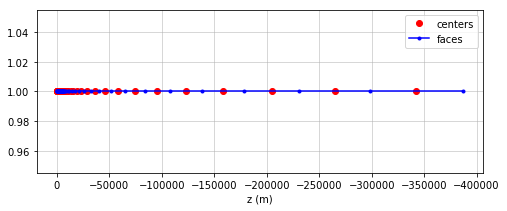

In [11]:
# plot the mesh
fig, ax = plt.subplots(1,1, figsize=(8, 3))
mesh.plotGrid(centers=True, faces=True, ax=ax)
ax.legend(["centers", "faces"])
ax.grid(which="both", linewidth=0.5)
ax.invert_xaxis()  # so that the surface is on our left hand side
ax.set_xlabel('z (m)')

## Set up a model

In the [previous notebook](./MT1D_Simulation.ipynb), we showed that for a half-space, we expect the apparent resistivity computed from impedance data to be the same as the half-space resistivity, and the phase to by $45^\circ$ across the entire frequency range. 

What happens when we include a conductive target in our model?

Here we will use the following model parameters
- Resistivity of the background: $\rho_{\text{halfspace}} = 100 \Omega m$ (which is the same as $\sigma_{\text{halfspace}} = 10^{-2} S/m$)
- Resistivity of the target: $\rho_{\text{target}} = 10 \Omega m$ (which is the same as $\sigma_{\text{halfspace}} = 10^{-1} S/m$)
- Thickness of the target layer: 1000m 
- Depth of the target layer: 2000m 

In [12]:
rho_target = 10.  # resistivity in Ohm-m
depth = 2000.  # depth to the top of the target in m 
thickness = 1000.  # thickness of the target in m

In [13]:
# put the model on the mesh
sigma = 1./rho_half * np.ones(mesh.nC)

# find the indices of the layer
layer_inds = (
    (mesh.vectorCCx<=-depth) & 
    (mesh.vectorCCx>-(depth+thickness))
)
sigma[layer_inds] = 1./rho_target

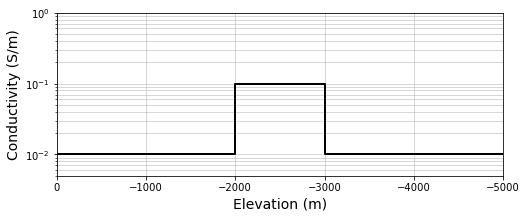

In [14]:
# plot the model
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

# trickery to plot from node to node rather than at cell centers
z = np.repeat(mesh.vectorNx[1:-1], 2, axis=0)
z = np.r_[mesh.vectorNx[0], z, mesh.vectorNx[-1]]
sigma_plt = np.repeat(sigma, 2, axis=0)

ax.semilogy(z, sigma_plt, "k", lw=2)
ax.grid(which="both", linewidth=0.5)
ax.set_xlim([-5000., 0.])
ax.set_ylim([5e-3, 1])
ax.invert_xaxis() # plot the surface on the left

ax.set_xlabel("Elevation (m)", fontsize=14)
ax.set_ylabel("Conductivity (S/m)", fontsize=14)

## Compare with an analytic

Prior to drawing conclusions from our simulations, we want to first make sure they are correct! 

So here, we compare the numerical results computed with our method `simulateMT` with an analytic for the MT response over a layered earth. A more complete description, including the derivation, is available on [EM GeoSci](http://em.geosci.xyz/content/maxwell3_fdem/natural_sources/MT_N_layered_Earth.html)

In [15]:
from SimPEG.EM.Analytics import MT_LayeredEarth

In [16]:
# the analytic takes the frequencies, layer thicknesses and layer conductivities
sigma_layers = np.r_[
    1./rho_half, 
    1./rho_target, 
    1./rho_half]
h = np.r_[depth, thickness]  

app_res_ana, app_phase_ana = MT_LayeredEarth(frequency, h, sigma_layers, 'Res-Phase')

In [17]:
# Uncomment to read the documentation on MT_LayeredEarth
# MT_LayeredEarth??

In [18]:
# numerically compute the response
app_res, app_phase = simulateMT(mesh, sigma, frequency)

In [19]:
def plot_with_analytic(frequency, app_res, app_phase, app_res_ana, app_phase_ana):
    # Plot and compare the results
    fig, ax = plt.subplots(2, 1, figsize=(8, 3*2))

    # apparent resistivity
    ax[0].loglog(frequency, app_res, 'k-', label='Numeric')
    ax[0].loglog(frequency, app_res_ana, 'k.', label='Analytic')
    ax[0].set_ylabel("$\\rho_a \ (\Omega m)$", fontsize=14)
    ax[0].set_ylim([2e1, 3e2])

    # phase
    ax[1].semilogx(frequency, app_phase, 'k-', label='Numeric')
    ax[1].semilogx(frequency, app_phase_ana, 'k.', label='Analytic')
    ax[1].set_ylabel("$\phi \ (^{\circ})$", fontsize=13)
    ax[1].set_ylim([0., 90.])

    for a in ax:
        a.grid(True, which='both', linewidth=0.3)
        a.set_xlim(frequency.max(), frequency.min())
        a.set_xlabel("Frequency (Hz)", fontsize=14)
        a.legend(fontsize=11)

    plt.tight_layout()
    plt.show()

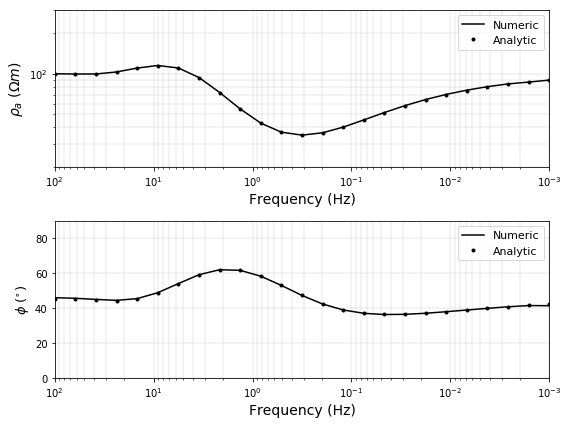

In [20]:
plot_with_analytic(frequency, app_res, app_phase, app_res_ana, app_phase_ana)

Across the entire frequency band, the apparent resistivity and phase agree with the analytic. What happens if

1. we use a coarse cell size?
2. we reduce how far the padding extends?

To answer those questions, we have a small widget. 

In [21]:
import ipywidgets

In [22]:
def mesh_design_app(domain_extent, cs):
    ncz = np.ceil(core_extent / cs)  # number of cells in the core domain
    
    # keep adding padding until we are beyond the desired extent
    npad=0
    padding_z = padding_extent(npad)
    while padding_z < domain_extent*1e3:
        npad+=1
        padding_z = padding_extent(npad)
    
    hz = [(cs, npad, -1.3), (cs, ncz)]  # define how to construct the cell widths
    mesh = Mesh.TensorMesh([hz], x0='N')  # construct a 1D Tensor Mesh

    # put the model on the mesh
    sigma = 1./rho_half * np.ones(mesh.nC)

    # find the indices of the layer
    layer_inds = (
        (mesh.vectorCCx<=-depth) & 
        (mesh.vectorCCx>-(depth+thickness))
    )
    sigma[layer_inds] = 1./rho_target
    
    app_res, app_phase = simulateMT(mesh, sigma, frequency)
    
    plot_with_analytic(frequency, app_res, app_phase, app_res_ana, app_phase_ana)

In [23]:
print(
    "It is helpful to remember that \n"
    "the minimum skin depth is {:1.0f}m \n"
    "and the maximum skin depth is {:1.0f}km".format(
        skin_depth_min, skin_depth_max*1e-3
    )
)

It is helpful to remember that 
the minimum skin depth is 500m 
and the maximum skin depth is 158km


- What happens if you make the domain smaller? Which frequencies are impacted first?
- What happens if you use a larger cell size? (Pay attention to the phase at high frequencies)
    - notice that there will be two regions impacted: high frequencies, and the frequencies impacted by the conductive layer

In [24]:
ipywidgets.interact(
    mesh_design_app,
    domain_extent=ipywidgets.FloatSlider(min=0, max=400, step=25, value=300, description="domain extent (km)"),
    cs=ipywidgets.FloatSlider(min=25, max=1000, step=25, value=125, description="min cell size (m)")
)

<function __main__.mesh_design_app>

### Considerations for the inversion

Prior to considering an inversion, first making sure that a suitable mesh is designed is an important step - otherwise, you can introduce artifacts and structures simply because the mesh doesn't capture the physics! Comparing against analytics that model a simplified, but similar, scenario can be a powerful tool for mesh design. 

## Non-uniqueness

The second concept we will explore with forward modelling is non-uniqueness: when models are different, but the data are similar.

In the Magnetotelluric problem, a classic example that demonstrates non-uniqueness of the data is the non-uniquness associated with the conductivity-thickness product of a thin layer. If we start with a layer that has a conductivity of $\sigma$, halve its thickness and double its conductivity, the resulting data will be similar... (but don't just take our word for it!)

In [25]:
# compute models with equivalent conductivity-thickness product
conductivity_thickness = thickness * 1./rho_target
layer_thicknesses = (np.arange(5)+1.)*300.
print("we consider layers having thicknesses (m) {}".format(layer_thicknesses))

we consider layers having thicknesses (m) [  300.   600.   900.  1200.  1500.]


In [26]:
sig_targets = conductivity_thickness / layer_thicknesses
print(
    "To preserve the conductivity thickness product,\n"
    "these layer have conductivities (S/m) of {}".format(sig_targets)
)
print("This is the same as resistivities (Ohm m) of {}".format(1./sig_targets))

To preserve the conductivity thickness product,
these layer have conductivities (S/m) of [ 0.33333333  0.16666667  0.11111111  0.08333333  0.06666667]
This is the same as resistivities (Ohm m) of [  3.   6.   9.  12.  15.]


In [27]:
# construct conductivity models on the mesh
sigma_list = []

# Compute the midpoint and make sure the layers we will compare with are all centered at the same depth 
depth_mid = depth + thickness / 2.

for i in range(len(layer_thicknesses)):
    layer_inds = (
        (mesh.vectorCCx<-depth_mid+layer_thicknesses[i]*0.5) & 
        (mesh.vectorCCx>-depth_mid-layer_thicknesses[i]*0.5)
    )
    sigma_temp = np.ones(mesh.nC) * 1./rho_half
    sigma_temp[layer_inds] = sig_targets[i]
    sigma_list.append(sigma_temp)

In [28]:
# compute the apparent resistivity and phase for each model
app_res_list = []
phase_list = []
for i in range(len(layer_thicknesses)):
    app_res, phase = simulateMT(mesh, sigma_list[i], frequency)
    app_res_list.append(app_res)
    phase_list.append(phase)

In [29]:
def plot_apparent_resistivities_and_phases(
    frequency, sigma_list, layer_thicknesses, app_res_list, phase_list, app_res_uncert=0., phase_uncert=0.
):
    """
    Plot the apparent resistivity and phase for multiple models
    
    frequency: numpy array of frequencies
    sigma_list: list of conductivity models to plot
    layer_thicknesses: thickness of the ~equivalent layers
    app_res_list: list of apparent resistivities computed from the conductivity models
    phase_list: list of phases computed fromt the conductivity models 
    app_res_uncert: uncertainty (in percentage) of the apparent resistivity
    phase_uncert: uncertainty (in degrees) of the phase  
    """
    fig, ax = plt.subplots(3, 1, figsize=(8, 3*3))

    for i in range(len(sigma_list)):
        # trickery to plot from node to node rather than at cell centers
        z = np.repeat(mesh.vectorNx[1:-1], 2, axis=0)
        z = np.r_[mesh.vectorNx[0], z, mesh.vectorNx[-1]]
        sigma_plt = np.repeat(sigma_list[i], 2, axis=0)

        # noise models, apparent resistivity is a percent, phase in units of degrees
        app_res_noise = (app_res_uncert/100.)*np.abs(app_res_list[i])*np.random.randn(len(app_res_list[i]))
        phase_noise = phase_uncert*np.random.randn(len(app_res_list[i]))

        ax[0].plot(z, sigma_plt, 'k', alpha=(i+1)*0.2, lw=2, label="t={:1.0f} m".format(layer_thicknesses[i]))
        ax[1].loglog(frequency, app_res_list[i]+app_res_noise, 'k-', alpha=(i+1)*0.2, lw=1)
        ax[2].semilogx(frequency, phase_list[i]+phase_noise, 'k-', alpha=(i+1)*0.2, lw=1)    

    # conductivity plot
    ax[0].set_title("(a) Conductivity models")
    ax[0].set_ylabel("Conductivity (S/m)")
    ax[0].set_xlabel("Depth (m)", fontsize=14)
    ax[0].set_xlim([-5000., 0.])
    ax[0].set_ylim([0, 0.4])
    ax[0].legend(fontsize=10, bbox_to_anchor=(1.21, 1.01))

    # apparent resistivity plot
    ax[1].set_title("(b) Apparent resistivity")
    ax[1].set_ylabel("$\\rho_a \ (\Omega m)$", fontsize=14)
    ax[1].set_ylim([2e1, 2e2])

    # phase plot
    ax[2].set_title("(c) Phase")
    ax[2].set_ylabel("$\phi \ (^{\circ})$", fontsize=14) 
    ax[2].set_ylim([0., 90.])

#     apparent resistivity and phase plots
    for a in ax[1:]:
        a.set_xlabel("Frequency (Hz)", fontsize=14)

    for a in ax:
        a.grid(True, which='both', linewidth=0.3)
        a.invert_xaxis()

    plt.tight_layout()
    plt.show()

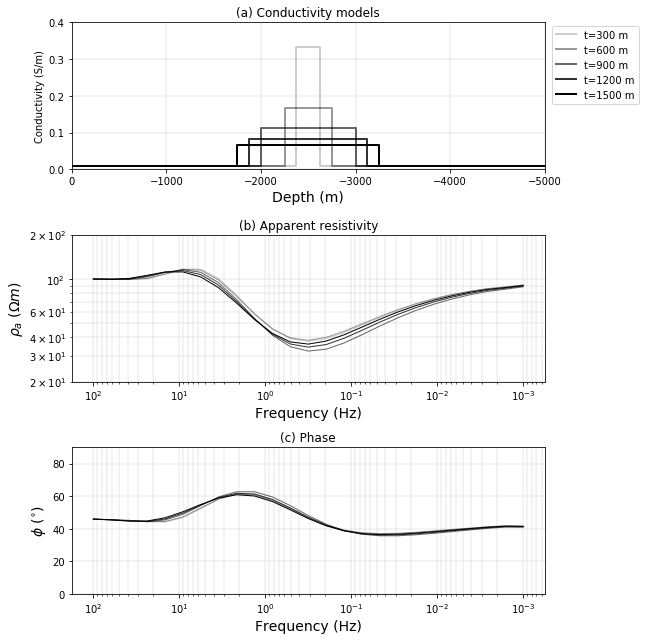

In [30]:
plot_apparent_resistivities_and_phases(frequency, sigma_list, layer_thicknesses, app_res_list, phase_list)

### What happens if we add noise??

In [31]:
ipywidgets.interact(
    lambda app_res_uncert, phase_uncert: plot_apparent_resistivities_and_phases(
        frequency, sigma_list, layer_thicknesses, app_res_list, phase_list, app_res_uncert, phase_uncert
    ),
    app_res_uncert = ipywidgets.FloatSlider(min=0., max=20., step=1, value=0., description="$\delta \\rho_a (\%)$"),
    phase_uncert = ipywidgets.FloatSlider(min=0., max=10., step=0.5, value=0., description="$\delta \phi (^\circ)$" )

)

<function __main__.<lambda>>

When setting expectations for what we can hope to get out of an inversion, it is important to keep non-uniquness in mind... Without additional information (eg. additional geophysical data, well logs, etc) that constrain the physical properties and geometries of our geologic setting, we cannot necessarily expect to nail down both the conductivity and geometry of a given geologic unit. 